In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import ast
import re
import string 
import scipy

C:\Users\Jessica Long\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
# Read file according to .txt format

def read_file(filename):
    file_dict = {}
    file = open(filename, 'r')
    lines = file.readlines()
    for line in lines:
        line = line.strip().split("|")
        key = line[0]
        line_dict = ast.literal_eval("{"+line[1]+"}")
        file_dict[key] = line_dict
    return(file_dict)

cluster0_dict = read_file('cluster0.txt')
tfidf_dict = read_file('tfidf.txt')

In [3]:
# Convert data
from sklearn.preprocessing import normalize

cluster0_df = pd.DataFrame.from_dict(cluster0_dict).transpose()
cluster0_df = cluster0_df.replace(np.nan,0) 
tfidf_df = pd.DataFrame.from_dict(tfidf_dict).transpose()
tfidf_df = tfidf_df.replace(np.nan,0) 

cluster0_mat = scipy.sparse.csr_matrix(cluster0_df.values)
tfidf_mat = normalize(scipy.sparse.csr_matrix(tfidf_df.values))
# Dense array
tfidf_arr = tfidf_mat.toarray()

print(len(tfidf_df))
# We have 15902 obs
# Want avg of 10-15 obs a cluster -> n = 1060-1590
# Test some points between the two 


15902


In [ ]:
# Test if code works with a small subsample of the data
tfidf_df = tfidf_df[0:100]
tfidf_mat = tfidf_mat[0:100]
tfidf_arr = tfidf_arr[0:100, :]


In [4]:
# Function for cluster centers

def compute_centers(data, labels):
    n = data.shape[0]
    k = max(labels)
    sums = np.zeros((k+1, data.shape[1]))
    counts = np.zeros((k+1, data.shape[1]))
    for i in range(n):
        j = labels[i]
        sums[j] += data[i]
        counts[j] += np.ones(data.shape[1])
    centers = sums / counts
    return centers

# Function for heterogeneity

def compute_heterogeneity(data, labels, centers):
    label_centers = np.array([centers[i] for i in labels])
    distance = (data - label_centers)**2
    return np.sum(distance)

# Plot heterogeneity, adopted from HW3
def plot_heterogeneity(k_list, heterogeneity):
    plt.figure(figsize=(7,4))
    plt.plot(k_list, heterogeneity,  marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of Clustering')
    plt.rcParams.update({'font.size': 12})
    plt.tight_layout()
    
# Plot silhouette score
def plot_score(k_list, score):
    plt.figure(figsize=(7,4))
    plt.plot(k_list, score,  marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score of Clustering')
    plt.rcParams.update({'font.size': 12})
    plt.tight_layout()
    
def size_distribution(labels_list, k_list):
    stats = {'k':  k_list, 'min': [], 'max': [],
             'q5': [], 'q10': [], 'q25': [], 'q50': [], 'q75': [], 'q90': [], 'q95': []}
    for labels in labels_list:
        unique, counts = np.unique(labels, return_counts=True)
        stats['min'].append(np.min(counts))
        stats['max'].append(np.max(counts))
        stats['q5'].append(np.quantile(counts, 0.05))
        stats['q10'].append(np.quantile(counts, 0.1))
        stats['q25'].append(np.quantile(counts, 0.25))
        stats['q50'].append(np.quantile(counts, 0.5))
        stats['q75'].append(np.quantile(counts, 0.75))
        stats['q90'].append(np.quantile(counts, 0.9))
        stats['q95'].append(np.quantile(counts, 0.95))
    stats = pd.DataFrame(stats)
    return stats
    
# Plot cluster size distribution
def plot_size(counts, model_name):
    plt.figure(figsize=(7,4))
    plt.hist(counts, bins=20)
    plt.xlabel('Cluster Size')
    plt.ylabel('Count')
    plt.title(model_name + ' Cluster Size Distribution')
    plt.rcParams.update({'font.size': 12})
    plt.tight_layout()

In [ ]:
# Fit K-means and get metrics

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

km_k_list = [k for k in range(1600, 1800, 10)]
#km_k_list = [k for k in range(2, 5)]
km_list = []
km_labels_list = []
km_centers_list = []
km_score_list = []
km_het_list = []
for k in km_k_list:
    print(k)
    kmeans = KMeans(n_clusters=k, init='k-means++').fit(tfidf_mat)
    km_list.append(kmeans)
    labels = kmeans.labels_
    km_labels_list.append(labels)
    centers = kmeans.cluster_centers_
    km_centers_list.append(centers)
    km_score_list.append(silhouette_score(tfidf_mat, labels, metric='euclidean'))
    km_het_list.append(compute_heterogeneity(tfidf_arr, labels, centers))

In [ ]:
# Store output
import pickle

filename = "kmeans_1"
kmeans_dict = {"km_k_list": km_k_list, "km_list": km_list, "km_labels_list": km_labels_list,
              "km_centers_list": km_centers_list, "km_score_list": km_score_list, "km_het_list": km_het_list}
with open(filename, "wb") as f:
    pickle.dump(kmeans_dict, f)
#with open(filename, "rb") as f:
#    kmeans_dict=pickle.load(f)


In [ ]:
# Plots 

plot_heterogeneity(km_k_list, km_het_list)
plot_score(km_k_list, km_score_list)

# Look at max silhouette score

maxs_km_index = np.argmax(km_score_list)
maxs_km = km_list[maxs_km_index]
maxs_km_k = km_k_list[maxs_km_index]
maxs_km_score = km_score_list[maxs_km_index]
print("k with highest score:", maxs_km_k)
print("Highest score:", maxs_km_score)

# Cluster size distribution
size_distribution(km_labels_list, km_k_list)

In [5]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

hca_k_list = [k for k in range(1600, 1800, 10)]
#hca_k_list = [k for k in range(2, 5)]
hca_list = []
hca_labels_list = []
hca_centers_list = []
hca_score_list = []
hca_het_list = []
for k in hca_k_list:
    print(k)
    hca = AgglomerativeClustering(n_clusters=k, linkage="average").fit(tfidf_arr)
    hca_list.append(hca)
    labels = hca.labels_
    hca_labels_list.append(labels)
    centers = compute_centers(tfidf_arr, labels)
    hca_centers_list.append(centers)
    hca_score_list.append(silhouette_score(tfidf_arr, labels, metric='euclidean'))
    hca_het_list.append(compute_heterogeneity(tfidf_arr, labels, centers))

1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790


In [6]:
# Store output
import pickle

filename = "hca_avg"
hca_dict = {"hca_k_list": hca_k_list, "hca_list": hca_list, "hca_labels_list": hca_labels_list,
              "hca_centers_list": hca_centers_list, "hca_score_list": hca_score_list, "hca_het_list": hca_het_list}
with open(filename, "wb") as f:
    pickle.dump(hca_dict, f)
#with open(filename, "rb") as f:
#    hca_dict=pickle.load(f)

k with highest score: 1790
Highest score: 0.054198866722908315


,k,min,max,q5,q10,q25,q50,q75,q90,q95
0,1600,1,461,2.0,3.0,4.0,6.0,10.00,18.0,27.00
1,1610,1,461,2.0,3.0,4.0,6.0,10.00,18.0,26.55
2,1620,1,461,2.0,3.0,4.0,6.0,10.00,18.0,26.00
3,1630,1,461,2.0,3.0,4.0,6.0,9.75,18.0,26.00
4,1640,1,461,2.0,3.0,4.0,5.0,9.00,18.0,26.00
5,1650,1,461,2.0,2.0,4.0,5.0,9.00,18.0,26.00
6,1660,1,461,2.0,2.0,3.0,5.0,9.00,18.0,26.00
7,1670,1,461,2.0,2.0,3.0,5.0,9.00,17.0,26.00
8,1680,1,461,2.0,2.0,3.0,5.0,9.00,17.0,26.00
9,1690,1,461,2.0,2.0,3.0,5.0,9.00,17.0,25.55


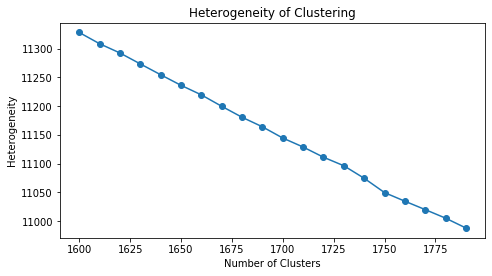

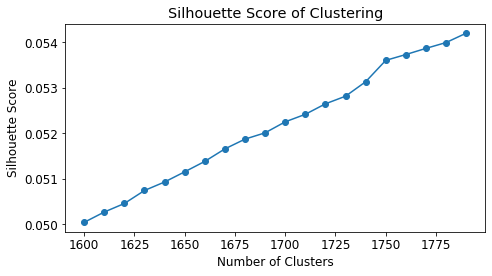

In [7]:
# Plots 

plot_heterogeneity(hca_k_list, hca_het_list)
plot_score(hca_k_list, hca_score_list)

# Look at max silhouette score

maxs_hca_index = np.argmax(hca_score_list)
maxs_hca = hca_list[maxs_hca_index]
maxs_hca_k = hca_k_list[maxs_hca_index]
maxs_hca_score = hca_score_list[maxs_hca_index]
print("k with highest score:", maxs_hca_k)
print("Highest score:", maxs_hca_score)

# Cluster size distribution
size_distribution(hca_labels_list, hca_k_list)

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import time
start = time.process_time()


sc_k_list = [k for k in range(1600, 1800, 25)]
#sc_k_list = [k for k in range(2, 5)]
sc_list = []
sc_labels_list = []
sc_centers_list = []
sc_score_list = []
sc_het_list = []
for k in sc_k_list:
    print(k)
    sc = SpectralClustering(n_clusters=k, affinity='nearest_neighbors',
                        assign_labels='kmeans')
    sc_list.append(sc)
    labels = sc.fit_predict(tfidf_mat)
    sc_labels_list.append(labels)
    centers = compute_centers(tfidf_arr, labels)
    sc_centers_list.append(centers)
    sc_score_list.append(silhouette_score(tfidf_mat, labels, metric='euclidean'))
    sc_het_list.append(compute_heterogeneity(tfidf_arr, labels, centers))
print(time.process_time() - start)

In [ ]:
# Store output
import pickle

filename = "sc_1"
sc_dict = {"sc_k_list": sc_k_list, "sc_list": sc_list, "sc_labels_list": sc_labels_list,
              "sc_centers_list": sc_centers_list, "sc_score_list": sc_score_list, "sc_het_list": sc_het_list}
with open(filename, "wb") as f:
    pickle.dump(sc_dict, f)
#with open(filename, "rb") as f:
#    sc_dict=pickle.load(f)

In [ ]:
# Plots 

plot_heterogeneity(sc_k_list, sc_het_list)
plot_score(sc_k_list, sc_score_list)

# Look at max silhouette score

maxs_sc_index = np.argmax(sc_score_list)
maxs_sc = sc_list[maxs_sc_index]
maxs_sc_k = sc_k_list[maxs_sc_index]
maxs_sc_score = sc_score_list[maxs_sc_index]
print("k with highest score:", maxs_sc_k)
print("Highest score:", maxs_sc_score)

# Cluster size distribution
size_distribution(sc_labels_list, sc_k_list)


In [ ]:
import pickle

filename = "dec_final"
with open(filename, "rb") as f:
    dec_dict=pickle.load(f)
print(dec_dict.keys())

In [ ]:
dec_k_list = dec_dict['dec_k_list']
dec_labels_list = dec_dict['dec_labels_list']
dec_centers_list = dec_dict['dec_centers_list']
dec_score_list = dec_dict['dec_score_list']
dec_het_list = dec_dict['dec_het_list']

# Plots 
plot_heterogeneity(dec_k_list, dec_het_list)
plot_score(dec_k_list, dec_score_list)

# Look at max silhouette score
maxs_dec_index = np.argmax(dec_score_list)
#maxs_dec = dec_labels_list[maxs_dec_index]
maxs_dec_k = dec_k_list[maxs_dec_index]
maxs_dec_score = dec_score_list[maxs_dec_index]
print("k with highest score:", maxs_dec_k)
print("Highest score:", maxs_dec_score)

# Cluster size distribution
size_distribution(dec_labels_list, dec_k_list)